<h1>Fitting IVT mechanistic model to Akama dataset<h1>

In this notebook, we will be showing how the figures in our paper were generated. We will be doing the following
    
    1. Performing local MAP optimization to fit our model to the dataset of Akama et al.
    2. Using a linearized model approximation to estimate a parameter covariance matrix. 
    3. Visualizing model fitting by plotting against fitting dataset
    4. Validating our model on new data (without fitting parameters)

<b>1. Importing required packages<b>

In [2]:
using Pkg
Pkg.activate("IVTmodel")
Pkg.instantiate()
using Distributed
using DifferentialEquations
using Plots
using NLopt
using LinearAlgebra
using Metrics
using CSV, DataFrames
using StaticArrays
using ForwardDiff
using NamedTupleTools
using BenchmarkTools
using ComponentArrays
using Distributions
using Statistics
using GenericLinearAlgebra
using DiffResults
using FLoops
using SharedArrays
using Plots.PlotMeasures
using FlexiMaps
using LaTeXStrings
using DelimitedFiles
using StatsBase
using NLsolve

include("./modules/model.jl")
include("./modules/parameterbackend.jl")
include("./modules/akamadataprocessing.jl")
include("./modules/akamaplotting.jl")
include("./modules/IVTplotting.jl")
include("./modules/modelfitting.jl")
include("./modules/residualcalculation.jl")
include("./modules/parameteruncertainty.jl")
include("./modules/predictionuncertainty.jl")
include("./modules/akamasensitivity.jl");

  Activating project at `C:\Users\ChemeGrad2021\Documents\Braatz Group\MRNA Synthesis\Published code\IVTmechanisticmodel\IVTmodel`
Precompiling project...
  ? Metrics


<b>2: Setting up model and importing data<b>

The following cell creates an object representing the parameters used in our model, whether they are fitted parameters or not, and their Bayesian priors. 
    
We also import required data for fitting and validation. 

In [3]:
#Generates settings for parameters used
fittingmodel = setupmodel()
#Imports calibration data from csv files
modeldata = importakamadata()
#Imports PPiase validation data
PPiasedata = importakamaPPiasedata();

<b>3: Optimizing Model<b>
    
We next fit the model to the Akama data set using MAP estimation. While in our work multistart optimization was used for this nonconvex problem, we use a local optimization here for simplicity. We will use a manually selected starting point that is near the optimum but not optimal.  

In [4]:
#Start at a manually selected warm start point
modorigin = [
  3.93
  5.13
  3.71
  2.30
 -3.692
 -3.8
 -4.50
  #0 #If using "ppiaseuncertainty = true" uncomment this line
 #-3.6695 #If using "ppiaseuncertainty = true" uncomment this line
 -0.26
  1.65
  4.47
  6.91
  2.08
  9.02
  3.30
  6.91
  2.08
  4.22
  1.84
  5.23
  3.99
 -3.95
]
modoriginparams = fullparameterset(fittingmodel,modorigin)
akamaresidual(fittingmodel,modeldata,modorigin) #Print loss of parameters applied to data.

1368.7116617893892

We then optimize the model and calculate a covariance matrix. Note that the loss should be decreasing until a tolerance is reached. 

In [5]:
optim=localopt(fittingmodel, modeldata,300,modorigin,akamaresidual,verbose = true)
fittedparamslist = optim[4]
fittedparams = fullparameterset(fittingmodel,fittedparamslist)
covariancemat = getcovariancematrix(fittingmodel,modeldata,fittedparamslist);
writedlm( "outputs/fittedparameters.csv",  fittedparamslist, ',')
writedlm( "outputs/covariancematrix.csv",  covariancemat, ',')
printresidual(fittingmodel,modeldata,fittedparamslist)

1368.7095504898243
48650.24466496236
38978.42068816599
9423.977672686191
1133.868969938109
1113.6031017935634
1063.652804621917
998.3546211109616
918.895754432008
906.7841135978406
900.6037318165579
894.0035869449218
881.3519624967948
867.9749508480667
853.1351242786352
847.3364992047482
838.703975796248
833.5956984889804
828.055604153899
819.066558360775
811.8467070154892
804.7940266683811
794.6113301710726
787.6989421576275
779.9217502419802
772.0540676079347
769.457901386676
768.4931372419748
767.5621644755848
765.5835643086563
761.8067250029387
760.7692345135117
760.2413246783794
760.1491971473548
760.0326498657774
759.7694251583846
758.9384572124263
757.622208841902
756.494994298787
756.0549649942699
755.9341900875111
755.5988748722731
754.5430228658917
753.3125116098038
751.9422974718805
751.2696038940346
751.1050817678488
751.0670648759108
751.0493711569947
751.0015089311034
750.9378758505594
750.8087798470476
750.6750193815693
750.5542317920833
750.5244575622968
750.52025927667

We can investigate the source of the loss between the datasets used in our calibration set. In this case, residuals are roughly proportional to the amount of "information" we get from each source. 

<b>4: Plotting Figures from Paper - Fitting Data<b>
    
Now that we have have successfully fit a set of parameters to our model, we can think about plotting our data alongside our model predictions. 

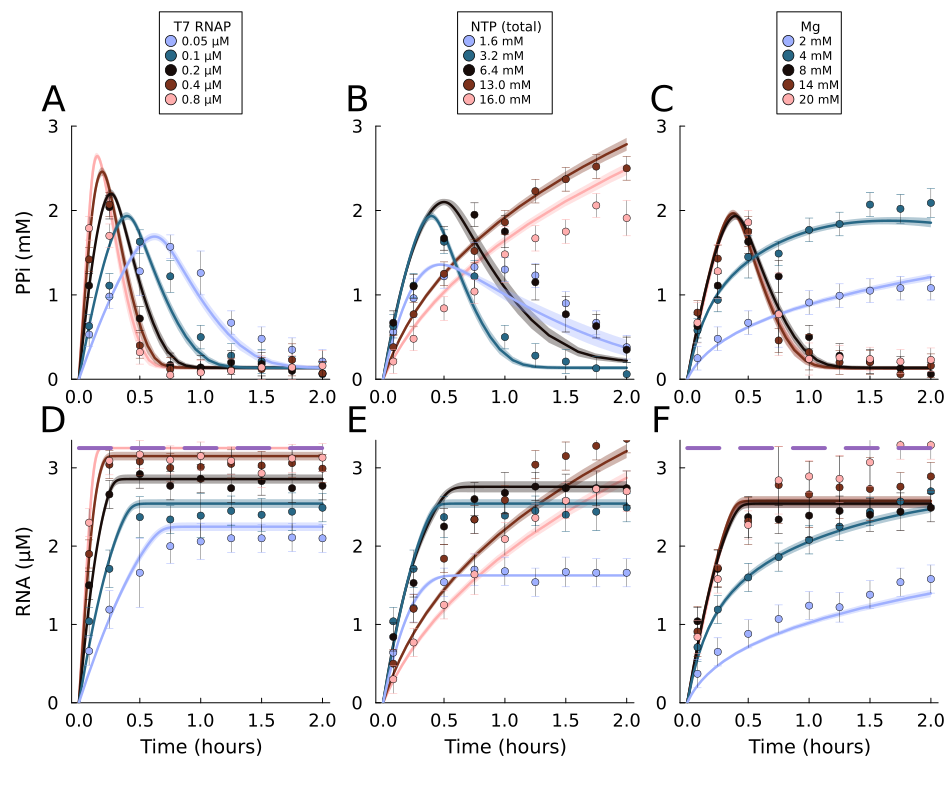

In [6]:
plt = revision1plot1(fittingmodel,modeldata, fittedparams, covariancemat, true,true)
savefig(plt,"figures/SIfigure2.pdf")
plt

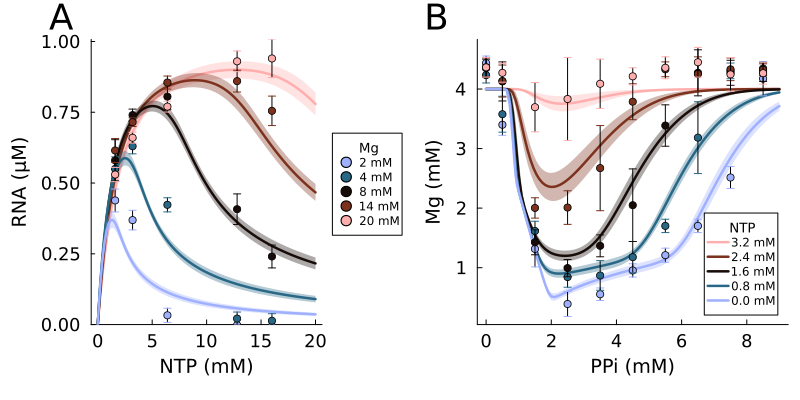

In [7]:
plt = revision1plot2(fittingmodel,modeldata, fittedparams, covariancemat, true,true)
savefig(plt,"figures/SIfigure3.pdf")
plt

<b>5: Plotting Figures from Paper - Validation Data<b>
    
Finally, we can apply our model to new data. See the main body of our paper for a complete description of what this data represents.

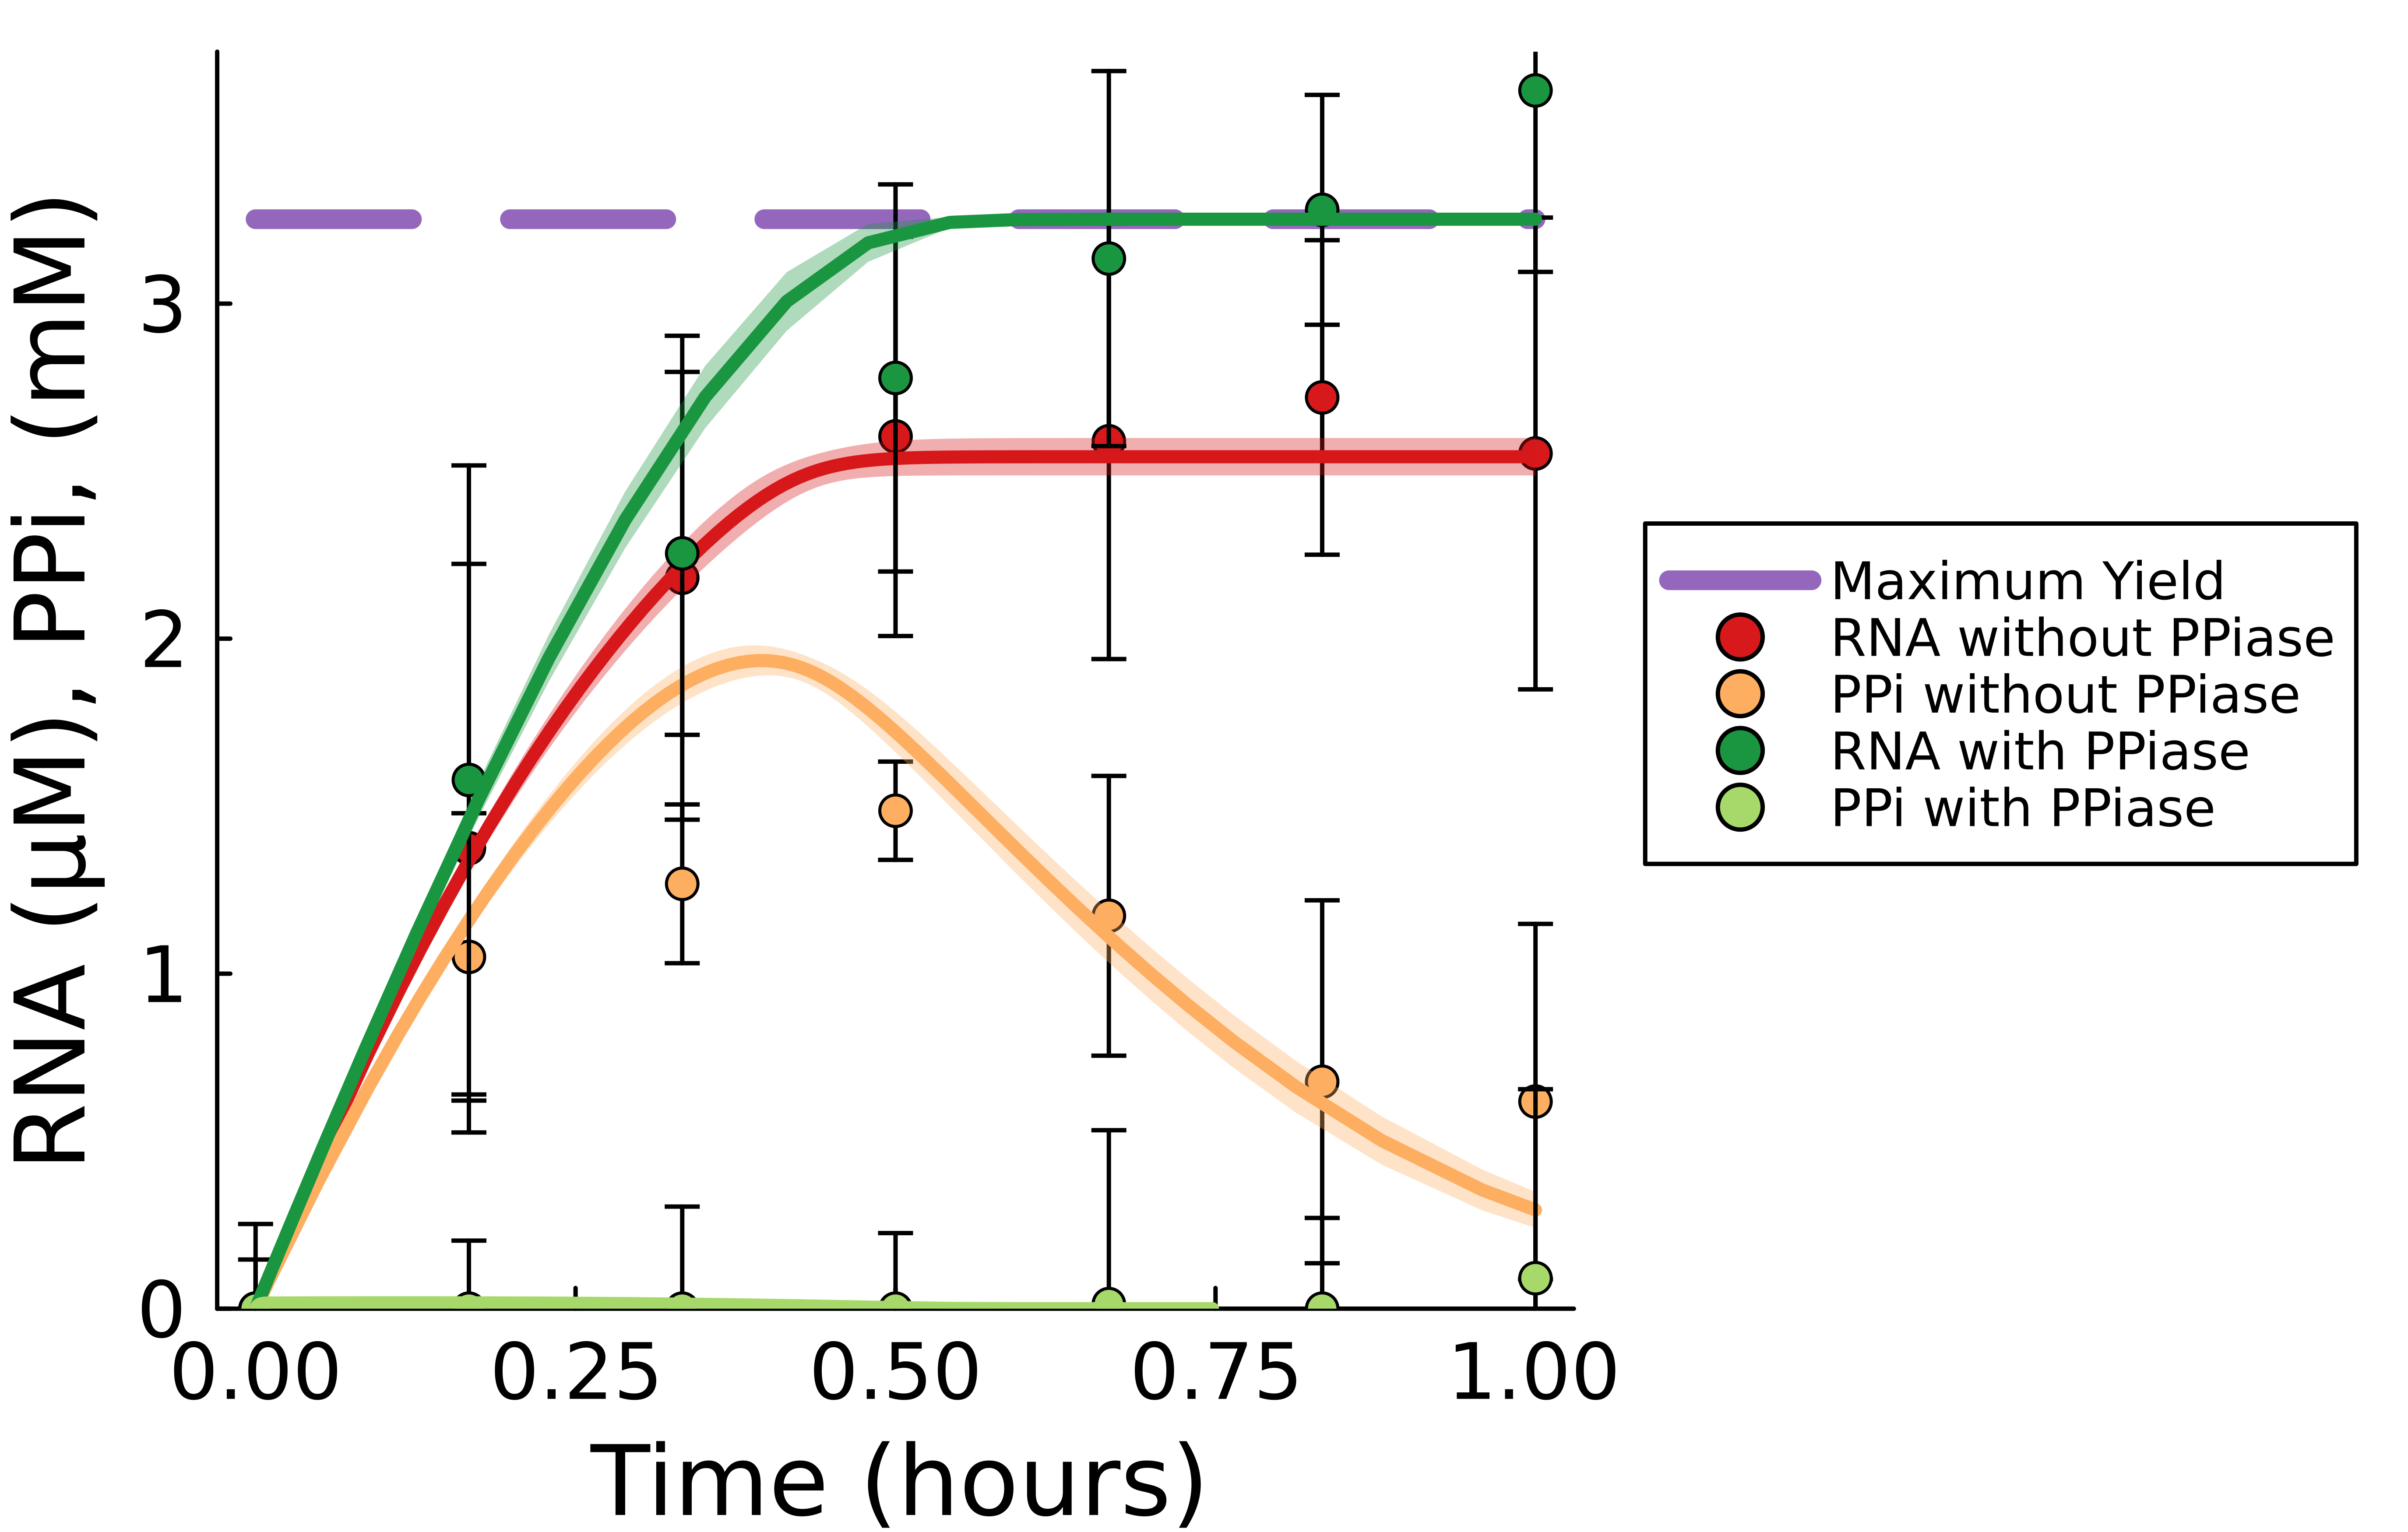

In [8]:
plt= plotakamaPPiase(PPiasedata, fittedparams, covariancemat,fittingmodel)
plot!(dpi = 1000)
savefig(plt,"figures/SIfigure4.pdf")
plt

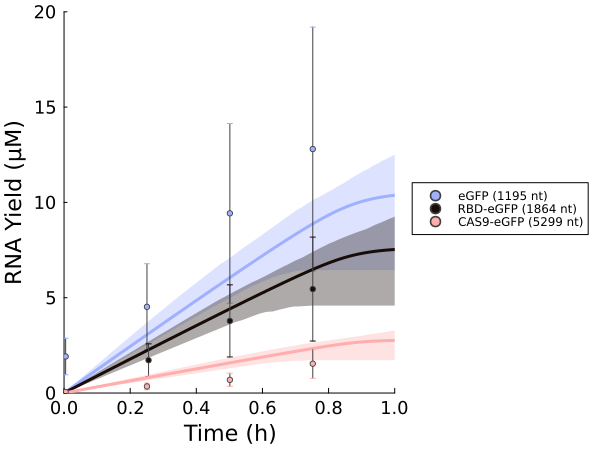

In [9]:
plt = plotfromcsv(fittingmodel,fittedparamslist,covariancemat,"data/rosadata.csv",range = [1,2,3],plotsize = (600,450),labels = ["eGFP (1195 nt)", "RBD-eGFP (1864 nt)", "CAS9-eGFP (5299 nt)"],dataerrorbars = true, multiplot = false,maximumyield = false)
plot!(xlims = (0,1),ylims = (0,20))
savefig(plt,"figures/SIfigure5.pdf")
plt